Ideas:

* Replicate project to get audio features of different artists and make visualization to compare them and cluster them into different categories based on their music - Top 100 artists? Do I have enough memory for that?
* Data visualization of Top 50 Songs of 2010s - look into Plotly and how to make cool data visualizations, and see how the sentiment of lyrics relates to their audio features
* Sentiment Analysis - are certain genres of music/artists correlated to depressive lyrics?

In [1]:
import numpy as np
import pandas as pd
import spotipy
import spotipy.util as util
import sys

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from ipywidgets import widgets, interactive
import plotly.figure_factory as ff
import plotly.graph_objs as go
from IPython.display import HTML
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

In [2]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

client_credentials_manager = SpotifyClientCredentials(client_id='99beb1b6bbc645b5a56f18415eaa2a1a',
                            client_secret='52c244a9dfdc406c8bce6bd7e37d9173')
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

#a95bdtzelsev82jnz0oskl530

playlists = sp.user_playlists('spotify')
#while playlists:
#    for i, playlist in enumerate(playlists['items']):
#        print("%4d %s %s" % (i + 1 + playlists['offset'], playlist['uri'],  playlist['name']))
#    if playlists['next']:
#        playlists = sp.next(playlists)
#    else:
#        playlists = None

In [3]:
def get_artist(name):
    results = sp.search(q='artist:' + name, type='artist')
    items = results['artists']['items']
    if len(items) > 0:
        return items[0]
    else:
        return None
get_artist("Drake")["uri"]

'spotify:artist:3TVXtAsR1Inumwj472S9r4'

In [4]:
def get_artist_audio_features(name):
    uri = get_artist(name)["uri"]
    artist = pd.DataFrame()
    for album in sp.artist_albums(uri)["items"]:
        for song in sp.album_tracks(album["uri"])["items"]:
            df = pd.DataFrame([sp.audio_features(song["uri"])[0]])
            df["Name"] = song["name"]
            cols = df.columns.tolist()
            cols = cols[-1:] + cols[:-1]
            df = df[cols]
            if artist.empty:
                artist = df
            else:
                artist = pd.concat([artist, df])
    return artist

In [5]:
jmayer = get_artist_audio_features("John Mayer")
cperri = get_artist_audio_features("Christina Perri")

In [6]:
enem = get_artist_audio_features("Eminem")

In [7]:
def polar_artist_stats(name, artist):
    obj = go.Scatterpolar(
        r=[
            np.median(artist['acousticness']),
            np.median(artist['danceability']),
            np.median(artist['energy']),
            np.median(artist['instrumentalness']),
            np.median(artist['liveness']),
            np.median(artist['speechiness']),
            np.median(artist['valence'])
            #tempo is another good feature to try to incorporate
        ],
        theta=[
            'acousticness', 'danceability', 'energy', 'instrumentalness', 
            'liveness', 'speechiness', 'valence'
        ],
        fill='toself',
        #marker=dict(
        #    color=colors[pkmn['Type 1'].values[0]]
        #),
        name=name
    )

    return obj

In [8]:
name1 = 'John Mayer'
name2 = 'Christina Perri'
name3 = "Eminem"

layout = go.Layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 1]
        )
    ),
    showlegend=True,
    title="{} vs. {} vs. {}".format(name1, name2, name3)
)

a1 = polar_artist_stats(name1, jmayer)
a2 = polar_artist_stats(name2, cperri)
a3 = polar_artist_stats(name3, enem)

compare_artists = go.Figure(data=[a1, a2, a3], layout=layout)
iplot(compare_artists, filename='Compare Artists')

In [9]:
# Creates dataframe containing the top 50 streamed songs of the 2010s 

tens_df = pd.DataFrame()
tens = sp.user_playlist_tracks('spotify', playlist_id='37i9dQZF1DWYJ5kmTbkZiz', fields = 'items')
for song in tens['items']:
    #gets name and uri
    ab = pd.DataFrame([sp.audio_features(song['track']['uri'])[0]])
    ab["Name"] = song['track']['name']
    artist = []
    for art in song['track']['artists']:
        artist.append(art['name'])
    ab["Artists"] = [artist]
    abcols = ab.columns.tolist()
    abcols = abcols[-1:] + abcols[:-1]
    abcols = abcols[-1:] + abcols[:-1]
    ab = ab[abcols]
    
    if tens_df.empty:
        tens_df = ab
    else:
        tens_df = pd.concat([tens_df, ab])
#list(tens['items'])

In [10]:
def polar_song_stats(song, itr = False):
    if itr == False:
        obj = go.Scatterpolar(
            r=[
                song['acousticness'].values[0],
                song['danceability'].values[0],
                song['energy'].values[0],
                song['instrumentalness'].values[0],
                song['liveness'].values[0],
                song['speechiness'].values[0],
                song['valence'].values[0],
            ],
            theta=[
                'acousticness', 'danceability', 'energy', 'instrumentalness', 
                'liveness', 'speechiness', 'valence'
            ],
            fill='toself',
            #marker=dict(
            #    color=colors[pkmn['Type 1'].values[0]]
            #),
            name=song["Name"].values[0]
        )
    else:
        obj = go.Scatterpolar(
            r=[
                song['acousticness'],
                song['danceability'],
                song['energy'],
                song['instrumentalness'],
                song['liveness'],
                song['speechiness'],
                song['valence'],
            ],
            theta=[
                'acousticness', 'danceability', 'energy', 'instrumentalness', 
                'liveness', 'speechiness', 'valence'
            ],
            fill='toself',
            #marker=dict(
            #    color=colors[pkmn['Type 1'].values[0]]
            #),
            name=song["Name"]
        )
        

    return obj

In [11]:
## Code block to make plotly visualization of top 50 of Spotify 2010s

song_choice = widgets.Dropdown(
    options=tens_df["Name"],
    value="One Dance",
    description='Song:',
)

s_layout = go.Layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 1]
        )
    ),
    showlegend=False,
    title="Spotify's Top 50 of the Decade: {}".format(song_choice.value)
)

#interactive(to_plot, graph = graph_choice, dat = data_choice)

top_50 = go.FigureWidget(data=[polar_song_stats(tens_df[tens_df["Name"] == "One Dance"])], layout=s_layout)

def validate(): 
    return True


def response(change):
    if validate():
        temp_df = tens_df[tens_df["Name"] == song_choice.value]

        x1 = polar_song_stats(temp_df)
        with top_50.batch_update():
            top_50.data[0].r = x1.r
            top_50.data[0].name = x1.name
            top_50.layout.title = title="Spotify's Top 50 of the Decade: {}".format(song_choice.value)
            #g.layout.barmode = 'overlay'
            #g.layout.xaxis.title = 'Delay in Minutes'
            #g.layout.yaxis.title = 'Number of Delays'


song_choice.observe(response, names="value")

widgets.VBox([song_choice,
              top_50])

In [12]:
tens_df

,Name,Artists,acousticness,analysis_url,danceability,duration_ms,energy,id,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,track_href,type,uri,valence
0,One Dance,"[Drake, WizKid, Kyla]",0.007760,https://api.spotify.com/v1/audio-analysis/1zi7...,0.792,173987,0.625,1zi7xx7UVEFkmKfv06H8x0,0.001880,1,0.3290,-5.609,1,0.0536,103.967,4,https://api.spotify.com/v1/tracks/1zi7xx7UVEFk...,audio_features,spotify:track:1zi7xx7UVEFkmKfv06H8x0,0.370
0,Lean On (feat. MØ & DJ Snake),"[Major Lazer, MØ, DJ Snake]",0.003460,https://api.spotify.com/v1/audio-analysis/1qE4...,0.723,176561,0.809,1qE47wUKG2juJwPoLqg4C9,0.001230,7,0.5650,-3.081,0,0.0625,98.007,4,https://api.spotify.com/v1/tracks/1qE47wUKG2ju...,audio_features,spotify:track:1qE47wUKG2juJwPoLqg4C9,0.274
0,Sunflower - Spider-Man: Into the Spider-Verse,"[Post Malone, Swae Lee]",0.533000,https://api.spotify.com/v1/audio-analysis/0RiR...,0.755,157560,0.522,0RiRZpuVRbi7oqRdSMwhQY,0.000000,2,0.0685,-4.368,1,0.0575,89.960,4,https://api.spotify.com/v1/tracks/0RiRZpuVRbi7...,audio_features,spotify:track:0RiRZpuVRbi7oqRdSMwhQY,0.925
0,Somebody That I Used To Know,"[Gotye, Kimbra]",0.548000,https://api.spotify.com/v1/audio-analysis/1qDr...,0.865,244885,0.521,1qDrWA6lyx8cLECdZE7TV7,0.000115,0,0.0989,-6.932,1,0.0371,129.059,4,https://api.spotify.com/v1/tracks/1qDrWA6lyx8c...,audio_features,spotify:track:1qDrWA6lyx8cLECdZE7TV7,0.748
0,Rolling in the Deep,[Adele],0.131000,https://api.spotify.com/v1/audio-analysis/1Ckv...,0.729,228293,0.756,1CkvWZme3pRgbzaxZnTl5X,0.000000,8,0.0527,-5.119,1,0.0294,104.945,4,https://api.spotify.com/v1/tracks/1CkvWZme3pRg...,audio_features,spotify:track:1CkvWZme3pRgbzaxZnTl5X,0.522
0,Can't Hold Us - feat. Ray Dalton,[Macklemore & Ryan Lewis],0.029100,https://api.spotify.com/v1/audio-analysis/3bid...,0.641,258343,0.922,3bidbhpOYeV4knp8AIu8Xn,0.000000,2,0.0862,-4.457,1,0.0786,146.078,4,https://api.spotify.com/v1/tracks/3bidbhpOYeV4...,audio_features,spotify:track:3bidbhpOYeV4knp8AIu8Xn,0.847
0,7 rings,[Ariana Grande],0.592000,https://api.spotify.com/v1/audio-analysis/6ocb...,0.778,178627,0.317,6ocbgoVGwYJhOv1GgI9NsF,0.000000,1,0.0881,-10.732,0,0.3340,140.048,4,https://api.spotify.com/v1/tracks/6ocbgoVGwYJh...,audio_features,spotify:track:6ocbgoVGwYJhOv1GgI9NsF,0.327
0,Wake Me Up,[Avicii],0.003800,https://api.spotify.com/v1/audio-analysis/4h8V...,0.532,247427,0.783,4h8VwCb1MTGoLKueQ1WgbD,0.001200,2,0.1610,-5.697,1,0.0523,124.080,4,https://api.spotify.com/v1/tracks/4h8VwCb1MTGo...,audio_features,spotify:track:4h8VwCb1MTGoLKueQ1WgbD,0.643
0,Love The Way You Lie,"[Eminem, Rihanna]",0.241000,https://api.spotify.com/v1/audio-analysis/15JI...,0.749,263373,0.925,15JINEqzVMv3SvJTAXAKED,0.000000,10,0.5200,-5.034,1,0.2270,86.989,4,https://api.spotify.com/v1/tracks/15JINEqzVMv3...,audio_features,spotify:track:15JINEqzVMv3SvJTAXAKED,0.641
0,bad guy,[Billie Eilish],0.328000,https://api.spotify.com/v1/audio-analysis/2Fxm...,0.701,194088,0.425,2Fxmhks0bxGSBdJ92vM42m,0.130000,7,0.1000,-10.965,1,0.3750,135.128,4,https://api.spotify.com/v1/tracks/2Fxmhks0bxGS...,audio_features,spotify:track:2Fxmhks0bxGSBdJ92vM42m,0.562


In [13]:
#import plotly.express as px
#fig = px.scatter(tens_df, x="valence", y="energy", hover_data=['Name'])
#fig.update_xaxes(range=[0, 1])
#fig.update_yaxes(range=[0, 1])

fig = go.Figure(data=go.Scatter(
    x=tens_df["valence"],
    y=tens_df["energy"],
    mode='markers',
    marker=dict(size=tens_df["tempo"] / 10),
    hovertext = tens_df["Name"]
),
    layout = {
    'shapes': [
        # Line Horizontal
        {
            'type': 'line',
            'x0': 0,
            'y0': 0.5,
            'x1': 1,
            'y1': 0.5,
            'line': {
                'color': 'rgb(50, 171, 96)',
                'width': 2
            },
        }, 
        {
            'type': 'line',
            'x0': 0.5,
            'y0': 0,
            'x1': 0.5,
            'y1': 1,
            'line': {
                'color': 'rgb(50, 171, 96)',
                'width': 2
            },
        },
        
        {
            'type': 'line',
            'x0': 0,
            'y0': np.mean(tens_df["energy"]),
            'x1': 1,
            'y1': np.mean(tens_df["energy"]),
            'line': {
                'color': 'red',
                'width': 2
            },
        }, 
        {
            'type': 'line',
            'x0': np.mean(tens_df["valence"]),
            'y0': 0,
            'x1': np.mean(tens_df["valence"]),
            'y1': 1,
            'line': {
                'color': 'red',
                'width': 2
            },
        }
    ],
    'showlegend': False
})

fig.update_layout(
    autosize=False,
    width=600,
    height=600,
    title="Spotify Top 50 of the 2010s",
    xaxis_title="Valence",
    yaxis_title="Energy",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="#7f7f7f"
    )
)


fig.update_xaxes(range=[0, 1])
fig.update_yaxes(range=[0, 1])

fig.show()
print("Valence:", np.mean(tens_df["valence"]))
print("Energy:", np.mean(tens_df["energy"]))

#layout(shapes = list(vline(4), hline(5)))

#fig.show()

Valence: 0.5732600000000001
Energy: 0.6638800000000002


In [14]:
songs = []

s_layout = go.Layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 1]
        )
    ),
    showlegend=False,
    title="Spotify's Top 50 of the Decade"
)

for index, song in tens_df.iterrows():
    songs.append(polar_song_stats(song, itr = True))

compare_songs = go.Figure(data=songs, layout=s_layout)
iplot(compare_songs, filename='Compare Artists')

In [15]:
artist = pd.DataFrame()
for song in sp.album_tracks('spotify:album:3yHOaiXecTJVUdn7mApZ48')['items']:
    df = pd.DataFrame([sp.audio_features(song["uri"])[0]])
    df["Name"] = song["name"]
    cols = df.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    df = df[cols]
    if artist.empty:
        artist = df
    else:
        artist = pd.concat([artist, df])
artist

,Name,acousticness,analysis_url,danceability,duration_ms,energy,id,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,track_href,type,uri,valence
0,No Such Thing,0.03830,https://api.spotify.com/v1/audio-analysis/6Vec...,0.668,231467,0.739,6Vecwo7AHst9V2CE3kmwr0,0.000000,4,0.1300,-4.919,1,0.0308,131.918,4,https://api.spotify.com/v1/tracks/6Vecwo7AHst9...,audio_features,spotify:track:6Vecwo7AHst9V2CE3kmwr0,0.571
0,Why Georgia,0.02080,https://api.spotify.com/v1/audio-analysis/1c7U...,0.608,268973,0.639,1c7UYTut2SBOPq64o2t0uN,0.000059,7,0.0893,-7.205,1,0.0246,96.915,4,https://api.spotify.com/v1/tracks/1c7UYTut2SBO...,audio_features,spotify:track:1c7UYTut2SBOPq64o2t0uN,0.369
0,My Stupid Mouth,0.01430,https://api.spotify.com/v1/audio-analysis/3jFP...,0.608,223960,0.603,3jFP1e8IUpD9QbltEI1Hcg,0.000012,2,0.0833,-6.792,1,0.0271,88.824,4,https://api.spotify.com/v1/tracks/3jFP1e8IUpD9...,audio_features,spotify:track:3jFP1e8IUpD9QbltEI1Hcg,0.490
0,Your Body Is a Wonderland,0.02060,https://api.spotify.com/v1/audio-analysis/7vFv...,0.647,249627,0.729,7vFv0yFGMJW3qVXbAd9BK9,0.048900,5,0.1340,-6.251,1,0.0236,94.010,4,https://api.spotify.com/v1/tracks/7vFv0yFGMJW3...,audio_features,spotify:track:7vFv0yFGMJW3qVXbAd9BK9,0.687
0,Neon,0.01810,https://api.spotify.com/v1/audio-analysis/7Koh...,0.699,262107,0.770,7Kohy4v3KLWfUXlv9N3feB,0.000138,5,0.0644,-7.658,0,0.0360,101.984,4,https://api.spotify.com/v1/tracks/7Kohy4v3KLWf...,audio_features,spotify:track:7Kohy4v3KLWfUXlv9N3feB,0.589
0,City Love,0.00576,https://api.spotify.com/v1/audio-analysis/5O3f...,0.651,240200,0.548,5O3fUsQQBFxW8SH1kHthDH,0.000056,5,0.1450,-6.036,1,0.0304,67.604,4,https://api.spotify.com/v1/tracks/5O3fUsQQBFxW...,audio_features,spotify:track:5O3fUsQQBFxW8SH1kHthDH,0.411
0,83,0.06770,https://api.spotify.com/v1/audio-analysis/0seE...,0.704,290933,0.838,0seE1aF8gzSPH79Dcvcbw2,0.006690,2,0.1210,-5.744,1,0.0289,121.972,4,https://api.spotify.com/v1/tracks/0seE1aF8gzSP...,audio_features,spotify:track:0seE1aF8gzSPH79Dcvcbw2,0.699
0,3x5,0.08470,https://api.spotify.com/v1/audio-analysis/2Knl...,0.502,289227,0.785,2Knlcf82LF6hp6Bf0gldtN,0.033700,5,0.1110,-6.640,0,0.0275,96.994,4,https://api.spotify.com/v1/tracks/2Knlcf82LF6h...,audio_features,spotify:track:2Knlcf82LF6hp6Bf0gldtN,0.590
0,Love Song for No One,0.03520,https://api.spotify.com/v1/audio-analysis/2L4n...,0.528,201560,0.755,2L4no3iw54gGX1ZwCNfYSL,0.000000,2,0.3450,-4.671,1,0.0311,144.024,4,https://api.spotify.com/v1/tracks/2L4no3iw54gG...,audio_features,spotify:track:2L4no3iw54gGX1ZwCNfYSL,0.432
0,Back to You,0.00698,https://api.spotify.com/v1/audio-analysis/3brC...,0.571,241640,0.835,3brCbW1KbGBUvMsqUhHQEy,0.000030,6,0.0639,-5.574,0,0.0327,101.940,4,https://api.spotify.com/v1/tracks/3brCbW1KbGBU...,audio_features,spotify:track:3brCbW1KbGBUvMsqUhHQEy,0.521


In [16]:
for album in sp.artist_albums(get_artist("John Mayer")["uri"])["items"]:
    print(album["name"], album["uri"])
    #for song in sp.album_tracks(album["uri"])["items"]:
        #print(song["name"], song["uri"])
        #print(song)

The Search for Everything spotify:album:0jZFu2tihRJ65iYAo0oOtP
Paradise Valley spotify:album:712VoD72K500yLhhgqCyVe
Born and Raised spotify:album:6S0BIiWtnqU0PtumXMpin0
Battle Studies spotify:album:1V5vQRMWTNGmqwxY8jMVou
Where the Light Is: John Mayer Live In Los Angeles spotify:album:4Dgxy95K9BWkDUvQPTaYBb
Continuum spotify:album:1Xsprdt1q9rOzTic7b9zYM
As/Is spotify:album:1QRIX6BuSGegYwiAZOv4R5
As/Is: Cleveland/Cincinnati, OH - 8/03-8/04/04 spotify:album:0u3x6X6FRE23fJEhPJoo6Q
As/Is: Houston, TX - 7/24/04 spotify:album:4rBHg7R3tDXJirsOrp4vG4
As/Is: Philadelphia, PA/Hartford, CT - 8/14-8/15/04 spotify:album:1hC2L9ZBeCSUsh6w3xzqN7
As/Is: Houston, TX - 7/24/04 spotify:album:5gsTckUr9I4z7uFHMheffb
As/Is: Mountain View, CA - 7/16/04 spotify:album:4ZxNekqkeVlCYcNdD0mnD7
Heavier Things spotify:album:6WivmTXugLZLmAWnZhlz7g
Any Given Thursday spotify:album:63dnCQnCOfPpLQU1aZvKE7
Any Given Thursday spotify:album:31Q7DQ751hbCO98r1ODhGt
Room For Squares spotify:album:3yHOaiXecTJVUdn7mApZ48
Inside

In [17]:
for item in sp.artist_top_tracks(get_artist("John Mayer")["uri"], country='US')["tracks"]:
    #print(item["name"], item["release_date"], sp.audio_features(item["uri"]))
    print(item)

{'album': {'album_type': 'single', 'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/0hEurMDQu99nJRq8pTxO14'}, 'href': 'https://api.spotify.com/v1/artists/0hEurMDQu99nJRq8pTxO14', 'id': '0hEurMDQu99nJRq8pTxO14', 'name': 'John Mayer', 'type': 'artist', 'uri': 'spotify:artist:0hEurMDQu99nJRq8pTxO14'}], 'external_urls': {'spotify': 'https://open.spotify.com/album/5fEgDYFPUcvQy21TYoLEZ0'}, 'href': 'https://api.spotify.com/v1/albums/5fEgDYFPUcvQy21TYoLEZ0', 'id': '5fEgDYFPUcvQy21TYoLEZ0', 'images': [{'height': 640, 'url': 'https://i.scdn.co/image/ab67616d0000b27321f02a52720857a42bba5417', 'width': 640}, {'height': 300, 'url': 'https://i.scdn.co/image/ab67616d00001e0221f02a52720857a42bba5417', 'width': 300}, {'height': 64, 'url': 'https://i.scdn.co/image/ab67616d0000485121f02a52720857a42bba5417', 'width': 64}], 'name': 'New Light', 'release_date': '2018-05-10', 'release_date_precision': 'day', 'total_tracks': 1, 'type': 'album', 'uri': 'spotify:album:5fEgDYFPUcvQy21T

In [18]:
sp.audio_analysis('spotify:track:7vFv0yFGMJW3qVXbAd9BK9')

{'meta': {'analyzer_version': '4.0.0',
  'platform': 'Linux',
  'detailed_status': 'OK',
  'status_code': 0,
  'timestamp': 1585192985,
  'analysis_time': 7.17411,
  'input_process': 'libvorbisfile L+R 44100->22050'},
 'track': {'num_samples': 5504268,
  'duration': 249.62667,
  'sample_md5': '',
  'offset_seconds': 0,
  'window_seconds': 0,
  'analysis_sample_rate': 22050,
  'analysis_channels': 1,
  'end_of_fade_in': 0.34803,
  'start_of_fade_out': 234.34159,
  'loudness': -6.251,
  'tempo': 94.01,
  'tempo_confidence': 0.634,
  'time_signature': 4,
  'time_signature_confidence': 1.0,
  'key': 5,
  'key_confidence': 0.611,
  'mode': 1,
  'mode_confidence': 0.519,
  'codestring': 'eJxVmwey5bgRBK_CI8Cb-19MmYU3s6OIlbTE5wOBNtXVRueO3sva6yvfLK3ctu7-eivfXau1c_i3tZtPi3_f57u3fauW6kL9aq_tO6f0WWu7Xx07j6uO619Xb9-YZd1bNn_dN3-td_bL453t27uvVcreX2v8dpW2-qmzfm2u8p3b755tzY-j8NhGKbOe5glLfltmK-Pr3VOVe_fxGH16gbHHvKfweH6nOvx4f6Oy8zijzT73_Eb3GPOuUW_jr7PmuoNL9c57fIi79NX6Od-svjxaL3Xe_s1RTl5e3RvNvcpPVL1sDsSZJ

## Sentiment Analysis

In [19]:
analyser = SentimentIntensityAnalyzer()

In [20]:
def sentiment_analyzer_scores(sentence):
    score = analyser.polarity_scores(sentence)
    print("{:-<40} {}".format(sentence, str(score)))

In [114]:
sentiment_analyzer_scores("Let it go, let it go \n Can't hold it back anymore \n Let it go, let it go \n Turn away and slam the door")

Let it go, let it go 
 Can't hold it back anymore 
 Let it go, let it go 
 Turn away and slam the door {'neg': 0.106, 'neu': 0.894, 'pos': 0.0, 'compound': -0.3818}


In [22]:
sentiment_analyzer_scores("Let it go, let it go \n Turn away and slam the door")

Let it go, let it go 
 Turn away and slam the door {'neg': 0.191, 'neu': 0.809, 'pos': 0.0, 'compound': -0.3818}


In [23]:
sentiment_analyzer_scores("Let it go, let it go \n Can't hold it back anymore \n Let it go, let it go" + 
                         " Turn away and slam the door")

Let it go, let it go 
 Can't hold it back anymore 
 Let it go, let it go Turn away and slam the door {'neg': 0.106, 'neu': 0.894, 'pos': 0.0, 'compound': -0.3818}


In [202]:
def wait_for(condition_function):
    start_time = time.time() 
    while time.time() < start_time + 5: 
        if condition_function(): 
            return True 
        else: 
            time.sleep(0.1) 
    raise Exception(
   'Timeout waiting for {}'.format(condition_function) 
  )

In [203]:
class wait_for_page_load(object):

    def __init__(self, browser):
        self.browser = browser
    
    def __enter__(self):
        self.old_page = self.browser.find_element_by_tag_name('html')
    
    def page_has_loaded(self):
        new_page = self.browser.find_element_by_tag_name('html')
        return new_page.id != self.old_page.id
    
    def __exit__(self, *_):
        wait_for(self.page_has_loaded)

In [24]:
from bs4 import BeautifulSoup
import time
from selenium.common.exceptions import StaleElementReferenceException
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.common.exceptions import TimeoutException

browser = webdriver.Chrome("../FEHeroes/chromedriver")
#gg = ("https://gamepress.gg/feheroes/heroes")
#browser.get(gg)
#respData = browser.page_source
search_string = "let+it+go+lyrics"

browser.get("https://www.google.com/search?q=" + search_string)
    #clickme = browser.find_element_by_xpath("//div[@class='hide-focus-ring pSO8Ic vk_arc']")
    #clickme = browser.find_element_by_xpath("//div[@aria-label='Show more']/div[@class='hide-focus-ring pSO8Ic vk_arc' and text()='Show more']")
    #clickme.click()
    #with wait_for_page_load(browser):
browser.find_element_by_xpath("//div[@class='hide-focus-ring pSO8Ic vk_arc']").click()
time.sleep(5)
    #WebDriverWait(browser, 20).until(lambda browser: browser.execute_script("return document.readyState;") == "complete")
    #browser.find_element_by_xpath("//div[@aria-label='Show more']/div[@class='hide-focus-ring pSO8Ic vk_arc' and text()='Show more']")
matched_elements = browser.page_source

browser.close()

In [25]:
nsoup = BeautifulSoup(matched_elements, 'html.parser')
nsoup.findAll('span', jsname = "YS01Ge")

[<span jsname="YS01Ge">The snow glows white on the mountain tonight</span>,
 <span jsname="YS01Ge">Not a footprint to be seen</span>,
 <span jsname="YS01Ge">A kingdom of isolation</span>,
 <span jsname="YS01Ge">And it looks like I'm the queen</span>,
 <span jsname="YS01Ge">The wind is howling like this swirling storm inside</span>,
 <span jsname="YS01Ge">Couldn't keep it in, heaven knows I've tried</span>,
 <span jsname="YS01Ge">Don't let them in, don't let them see</span>,
 <span jsname="YS01Ge">Be the good girl you always have to be</span>,
 <span jsname="YS01Ge">Conceal, don't feel, don't let them know</span>,
 <span jsname="YS01Ge">Well, now they know</span>,
 <span jsname="YS01Ge">Let it go, let it go</span>,
 <span jsname="YS01Ge">Can't hold it back anymore</span>,
 <span jsname="YS01Ge">Let it go, let it go</span>,
 <span jsname="YS01Ge">Turn away and slam the door</span>,
 <span jsname="YS01Ge">I don't care what they're going to say</span>,
 <span jsname="YS01Ge">Let the storm 

In [85]:
nsoup = BeautifulSoup(matched_elements, 'html.parser')

In [145]:
nsoup.findAll('div', attrs={'aria-label':'Show more'})

[<div aria-controls="tsuid27" aria-expanded="false" aria-label="Show more" class="hide-focus-ring pSO8Ic vk_arc" data-fbevent="fastbutton" data-ved="2ahUKEwi8qaD_4fjnAhXPrJ4KHclQDksQxRkoAXoECA4QBg" jsaction="kx.t; fastbutton: kx.t" role="button" style="clear:both" tabindex="0"><div class="vk_ard"></div></div>]

In [144]:
nsoup.findAll('div', role = "button")

[<div aria-label="Search by voice" class="hpuQDe" data-ved="0ahUKEwi8qaD_4fjnAhXPrJ4KHclQDksQvs8DCAo" jsaction="h5M12e;rcuQ6b:npT2md" jscontroller="MC8mtf" role="button" tabindex="0"><span class="HPVvwb"></span></div>,
 <div aria-haspopup="true" aria-label="Any time" class="hdtb-mn-hd" role="button" tabindex="0"><div class="mn-hd-txt">Any time</div><span class="mn-dwn-arw"></span></div>,
 <div class="Gwgzqd" jsaction="xp3IKd" role="button" tabindex="0"></div>,
 <div aria-haspopup="true" aria-label="All results" class="hdtb-mn-hd" role="button" tabindex="0"><div class="mn-hd-txt">All results</div><span class="mn-dwn-arw"></span></div>,
 <div aria-controls="tsuid27" aria-expanded="false" aria-label="Show more" class="hide-focus-ring pSO8Ic vk_arc" data-fbevent="fastbutton" data-ved="2ahUKEwi8qaD_4fjnAhXPrJ4KHclQDksQxRkoAXoECA4QBg" jsaction="kx.t; fastbutton: kx.t" role="button" style="clear:both" tabindex="0"><div class="vk_ard"></div></div>,
 <div class="NhRr3b" data-ved="2ahUKEwi8qaD_4

<html itemscope="" itemtype="http://schema.org/SearchResultsPage" lang="en"><head><meta content="/images/branding/googleg/1x/googleg_standard_color_128dp.png" itemprop="image"/><meta content="origin" name="referrer"/><title>let it go lyrics - Google Search</title><script async="" nonce="eRbJ5W7OwDRclfvd6n7wUQ==" src="https://apis.google.com/_/scs/abc-static/_/js/k=gapi.gapi.en.OfYsKuVZ3qI.O/m=gapi_iframes,googleapis_client,plusone/rt=j/sv=1/d=1/ed=1/rs=AHpOoo8UDq_6isr1vipw5cUlPTPPdx3_0A/cb=gapi.loaded_0"></script><script nonce="eRbJ5W7OwDRclfvd6n7wUQ==">(function(){window.google={kEI:'YlRbXt_ULNXK-gSs7LnQBQ',kEXPI:'31',kBL:'q7xS'};google.sn='web';google.kHL='en';})();(function(){google.lc=[];google.li=0;google.getEI=function(a){for(var b;a&&(!a.getAttribute||!(b=a.getAttribute("eid")));)a=a.parentNode;return b||google.kEI};google.getLEI=function(a){for(var b=null;a&&(!a.getAttribute||!(b=a.getAttribute("leid")));)a=a.parentNode;return b};google.ml=function(){return null};google.time=fu
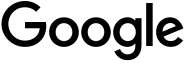
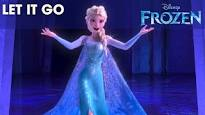
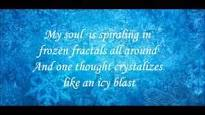
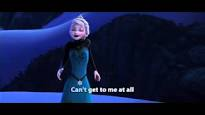
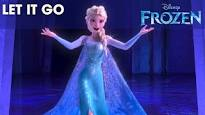
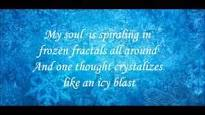
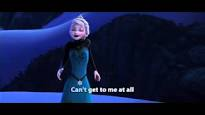

In [57]:
nsoup

In [86]:
nsoup.findAll('span', jsname = "YS01Ge")

[<span jsname="YS01Ge">The snow glows white on the mountain tonight</span>,
 <span jsname="YS01Ge">Not a footprint to be seen</span>,
 <span jsname="YS01Ge">A kingdom of isolation</span>,
 <span jsname="YS01Ge">And it looks like I'm the queen</span>,
 <span jsname="YS01Ge">The wind is howling like this swirling storm inside</span>,
 <span jsname="YS01Ge">Couldn't keep it in, heaven knows I've tried</span>,
 <span jsname="YS01Ge">Don't let them in, don't let them see</span>,
 <span jsname="YS01Ge">Be the good girl you always have to be</span>,
 <span jsname="YS01Ge">Conceal, don't feel, don't let them know</span>,
 <span jsname="YS01Ge">Well, now they know</span>,
 <span jsname="YS01Ge">Let it go, let it go</span>,
 <span jsname="YS01Ge">Can't hold it back anymore</span>,
 <span jsname="YS01Ge">Let it go, let it go</span>,
 <span jsname="YS01Ge">Turn away and slam the door</span>,
 <span jsname="YS01Ge">I don't care what they're going to say</span>,
 <span jsname="YS01Ge">Let the storm 

In [89]:
browser = webdriver.Chrome("../FEHeroes/chromedriver")
#gg = ("https://gamepress.gg/feheroes/heroes")
#browser.get(gg)
#respData = browser.page_source
searchi_string = "we+are+young+featuring+janelle+monae+lyrics"

for i in range(1): 
    browser.get("https://www.google.com/search?q=" + searchi_string)
    elements = browser.page_source

browser.close()

In [88]:
soup = BeautifulSoup(elements, 'html.parser')
soup.findAll('span', jsname = "YS01Ge")

[<span jsname="YS01Ge">Give me a second I</span>,
 <span jsname="YS01Ge">I need to get my story straight</span>,
 <span jsname="YS01Ge">My friends are in the bathroom getting higher than the Empire State</span>,
 <span jsname="YS01Ge">My lover she's waiting for me just across the bar</span>,
 <span jsname="YS01Ge">My seat's been taken by some sunglasses asking about a scar, and</span>,
 <span jsname="YS01Ge">I know I gave it to you months ago</span>,
 <span jsname="YS01Ge">I know you're trying to forget</span>,
 <span jsname="YS01Ge">But between the drinks and subtle things</span>,
 <span jsname="YS01Ge">The holes in my apologies, you know</span>,
 <span jsname="YS01Ge">I'm trying hard to take it back</span>,
 <span jsname="YS01Ge">So if by the time the bar closes</span>,
 <span jsname="YS01Ge">And you feel like falling down, I'll carry you home</span>,
 <span jsname="YS01Ge">Tonight, we are young</span>,
 <span jsname="YS01Ge">So let's set the world on fire</span>,
 <span jsname="YS01

In [84]:
browser = webdriver.Chrome("../FEHeroes/chromedriver")
#gg = ("https://gamepress.gg/feheroes/heroes")
#browser.get(gg)
#respData = browser.page_source
singer = "shakira"
song = "wakawakathistimeforafrica"

for i in range(1): 
    browser.get("https://www.azlyrics.com/lyrics/" + singer + "/" + song + ".html")
    el = browser.page_source

browser.close()

In [85]:
so = BeautifulSoup(el, 'html.parser')

In [86]:
so

<html lang="en"><head>
<meta charset="utf-8"/>
<meta content="IE=edge" http-equiv="X-UA-Compatible"/>
<meta content="width=device-width, initial-scale=1" name="viewport"/>
<meta content="Shakira &quot;Waka Waka (This Time For Africa)&quot;: Oooeeeeeeeeeeeeeeeehh You're a good soldier Choosing your battles Pick yourself up And dust yoursel..." name="description"/>
<meta content="Waka Waka (This Time For Africa) lyrics, Shakira Waka Waka (This Time For Africa) lyrics, Shakira lyrics" name="keywords"/>
<meta content="noarchive" name="robots"/>
<meta content="//www.azlyrics.com/az_logo_tr.png" property="og:image"/>
<title>Shakira - Waka Waka (This Time For Africa) Lyrics | AZLyrics.com</title>
<link href="https://maxcdn.bootstrapcdn.com/bootstrap/3.3.4/css/bootstrap.min.css" rel="stylesheet"/>
<link href="//www.azlyrics.com/bsaz.css?4" rel="stylesheet"/>
<!-- HTML5 shim and Respond.js for IE8 support of HTML5 elements and media queries -->
<!--[if lt IE 9]>
<script src="https://oss.maxcdn.

In [87]:
so.findAll(text = True)

['\n',
 '\n',
 '\n',
 '\n',
 '\n',
 '\n',
 '\n',
 '\n',
 'Shakira - Waka Waka (This Time For Africa) Lyrics | AZLyrics.com',
 '\n',
 '\n',
 '\n',
 ' HTML5 shim and Respond.js for IE8 support of HTML5 elements and media queries ',
 '\n',
 '[if lt IE 9]>\n<script src="https://oss.maxcdn.com/html5shiv/3.7.2/html5shiv.min.js"></script>\n<script src="https://oss.maxcdn.com/respond/1.4.2/respond.min.js"></script>\n<![endif]',
 '\n',
 '\n',
 '\n',
 '\n',
 '\n',
 '\nArtistName = "Shakira";\nSongName = "Waka Waka (This Time For Africa)";\nfunction submitCorrections(){\n\tdocument.getElementById(\'corlyr\').submit();\n\treturn false;\n}\n',
 '\n',
 '\n',
 'googleoff: all',
 'To personalize content, ads and provide a better experience we use cookies. By continuing to browse our site you agree to our use of cookies. Learn more or change your cookie preferences from our  ',
 'Cookie Policy',
 'Got it!',
 'googleon: all',
 '\n',
 '\n',
 '\n',
 ' Brand and toggle get grouped for better mobile display

In [88]:
beg = so.findAll(text = True).index(' Usage of azlyrics.com content by any third-party lyrics provider is prohibited by our licensing agreement. Sorry about that. ')
en = so.findAll(text = True).index(' MxM banner ')

In [89]:
#so.findAll(text = True)[beg + 1:en].apply(strip("/n"))
lyr = [x.strip("\n") for x in so.findAll(text = True)[beg + 1:en]]
lyr

['Oooeeeeeeeeeeeeeeeehh',
 '',
 "You're a good soldier",
 'Choosing your battles',
 'Pick yourself up',
 'And dust yourself off',
 'Get back in the saddle',
 '',
 "You're on the front line",
 "Everyone's watching",
 "You know it's serious",
 "We're getting closer",
 "This isn't over",
 '',
 "The pressure's on",
 'You feel it',
 'But you got it all',
 'Believe it',
 '',
 'When you fall get up, oh oh',
 'If you fall get up, eh eh',
 'Tsamina mina zangalewa',
 "'Cause this is Africa",
 '',
 'Tsamina mina, eh eh',
 'Waka waka, eh eh',
 'Tsamina mina zangalewa',
 'This time for Africa',
 '',
 'Listen to your God',
 'This is our motto',
 'Your time to shine',
 "Don't wait in line",
 'Y vamos por todo',
 '',
 'People are raising',
 'Their expectations',
 'Go on and feed them',
 'This is your moment',
 'No hesitation',
 '',
 "Today's your day",
 'I feel it',
 'You paved the way',
 'Believe it',
 '',
 'If you get down get up, oh oh',
 'When you get down get up, eh eh',
 'Tsamina mina zangalewa'

In [90]:
sentiment_analyzer_scores(" ".join(lyr))

Oooeeeeeeeeeeeeeeeehh  You're a good soldier Choosing your battles Pick yourself up And dust yourself off Get back in the saddle  You're on the front line Everyone's watching You know it's serious We're getting closer This isn't over  The pressure's on You feel it But you got it all Believe it  When you fall get up, oh oh If you fall get up, eh eh Tsamina mina zangalewa 'Cause this is Africa  Tsamina mina, eh eh Waka waka, eh eh Tsamina mina zangalewa This time for Africa  Listen to your God This is our motto Your time to shine Don't wait in line Y vamos por todo  People are raising Their expectations Go on and feed them This is your moment No hesitation  Today's your day I feel it You paved the way Believe it  If you get down get up, oh oh When you get down get up, eh eh Tsamina mina zangalewa This time for Africa  Tsamina mina, eh eh Waka waka, eh eh Tsamina mina zangalewa Anawa a a Tsamina mina, eh eh Waka waka, eh eh Tsamina mina zangalewa This time for Africa   [Zolani:] Ame la me

In [129]:
so.findAll("div")[19]

<div>
<!-- Usage of azlyrics.com content by any third-party lyrics provider is prohibited by our licensing agreement. Sorry about that. -->
The snow glows white on the mountain tonight<br/>
Not a footprint to be seen<br/>
A kingdom of isolation<br/>
And it looks like I'm the queen<br/>
<br/>
The wind is howling like this swirling storm inside<br/>
Couldn't keep it in, heaven knows I tried!<br/>
<br/>
Don't let them in, don't let them see<br/>
Be the good girl you always have to be<br/>
Conceal, don't feel, don't let them know<br/>
Well, now they know!<br/>
<br/>
Let it go, let it go<br/>
Can't hold it back anymore<br/>
Let it go, let it go<br/>
Turn away and slam the door!<br/>
<br/>
I don't care<br/>
What they're going to say<br/>
Let the storm rage on<br/>
The cold never bothered me anyway!<br/>
<br/>
It's funny how some distance<br/>
Makes everything seem small<br/>
And the fears that once controlled me<br/>
Can't get to me at all!<br/>
<br/>
It's time to see what I can do<br/>
To t

In [33]:
so.findAll("div")[25]

<div style="color: #213374 !important; padding: 0px 8px !important; font-size: 15px !important; font-weight: bold !important; line-height: 1.5;">            Play "Let It Go"<br/> </div>

In [35]:
browser = webdriver.Chrome("../FEHeroes/chromedriver")
#gg = ("https://gamepress.gg/feheroes/heroes")
#browser.get(gg)
#respData = browser.page_source
singer = "xxxtentacion"
song = "sad"

for i in range(1): 
    browser.get("https://www.azlyrics.com/lyrics/" + singer + "/" + song + ".html")
    eles = browser.page_source

browser.close()

In [36]:
s = BeautifulSoup(eles, 'html.parser')
s.findAll("div")[14]

<div class="row">
<div class="col-lg-2 text-center hidden-md hidden-sm hidden-xs noprint">
<div class="sky-ad"></div>
</div>
<!-- content -->
<div class="col-xs-12 col-lg-8 text-center">
<div class="div-share noprint">
<div class="addthis_toolbox addthis_default_style">
<a class="btn btn-xs btn-share addthis_button_facebook" href="https://www.facebook.com/sharer.php?u=https%3A%2F%2Fwww.azlyrics.com%2Flyrics%2Fxxxtentacion%2Fsad.html&amp;title=XXXTENTACION%20-%20SAD%21%20Lyrics%20%7C%20AZLyrics.com&amp;display=page" target="_blank">
<span class="playblk"><img alt="Share on Facebook" class="playblk" height="25" src="//www.azlyrics.com/images/share-icons/facebook.svg" title="Share on Facebook" width="25"/></span>
</a>
<a class="btn btn-xs btn-share addthis_button_twitter" href="https://twitter.com/intent/tweet?url=https%3A%2F%2Fwww.azlyrics.com%2Flyrics%2Fxxxtentacion%2Fsad.html&amp;text=XXXTENTACION%20-%20SAD%21%20Lyrics%20%7C%20AZLyrics.com" target="_blank">
<span class="playblk"><img a

In [37]:
s.find('div', text = "Yeah")

In [38]:
begi = s.findAll(text = True).index(' Usage of azlyrics.com content by any third-party lyrics provider is prohibited by our licensing agreement. Sorry about that. ')
endo = s.findAll(text = True).index(' MxM banner ')
lyrim = [x.strip("\n") for x in s.findAll(text = True)[begi + 1:endo]]
sentiment_analyzer_scores(" ".join(lyrim))

Yeah  Who am I? Someone that's afraid to let go, uh You decide if you're ever gonna let me know (yeah) Suicide if you ever try to let go, uh I'm sad, I know, yeah, I'm sad, I know, yeah Who am I? Someone that's afraid to let go, uh You decide if you're ever gonna let me know (yeah) Suicide if you ever try to let go, uh I'm sad, I know, yeah, I'm sad, I know, yeah  I gave her everything She took my heart and left me lonely I think broken heart's contagious I won't fix, I'd rather weep I'm lost then I'm found But it's torture being in love I love when you're around But I fucking hate when you leave  Who am I? Someone that's afraid to let go, uh You decide if you're ever gonna let me know (yeah) Suicide if you ever try to let go, uh I'm sad, I know, yeah I'm sad, I know, yeah Who am I? Someone that's afraid to let go, uh You decide if you're ever gonna let me know (yeah) Suicide if you ever try to let go, uh I'm sad, I know, yeah I'm sad, I know, yeah  Who am I? Someone that's afraid to l

In [39]:
sentiment_analyzer_scores(" ".join(lyrim))

Yeah  Who am I? Someone that's afraid to let go, uh You decide if you're ever gonna let me know (yeah) Suicide if you ever try to let go, uh I'm sad, I know, yeah, I'm sad, I know, yeah Who am I? Someone that's afraid to let go, uh You decide if you're ever gonna let me know (yeah) Suicide if you ever try to let go, uh I'm sad, I know, yeah, I'm sad, I know, yeah  I gave her everything She took my heart and left me lonely I think broken heart's contagious I won't fix, I'd rather weep I'm lost then I'm found But it's torture being in love I love when you're around But I fucking hate when you leave  Who am I? Someone that's afraid to let go, uh You decide if you're ever gonna let me know (yeah) Suicide if you ever try to let go, uh I'm sad, I know, yeah I'm sad, I know, yeah Who am I? Someone that's afraid to let go, uh You decide if you're ever gonna let me know (yeah) Suicide if you ever try to let go, uh I'm sad, I know, yeah I'm sad, I know, yeah  Who am I? Someone that's afraid to l

In [96]:
def azartistprep(artist):
    if "&" in artist:
        art, tist = artist.split("&")
        return art.lower().replace(" ", "").replace(".", "")
    if "The" in artist:
        art, tist = artist.split("The")
        return tist.lower().replace(" ", "").replace(".", "")
    return artist.lower().replace(" ", "").replace(".", "")

def azlyricprep(song):
    if " - " in song:
        end = ""
        a, b = song.split("-", 1)
        if a == "Cheerleader":
            return "cheerleaderfelixjaehnremix"
        if "Remix" in b:
            c, d = b.split("Remix")
            end += c.lower().replace(" ", "") + "remix"
        a = a.lower().replace(" ", "")
        a += end
        return a.replace("'", "").replace("!", "").replace(".", "")
    if "[" in song:
        a, b = song.split("[", 1)
        a = a.lower().replace("(", "").replace(")", "").replace(" ", "")
        return a.replace("'", "").replace("!", "").replace(".", "")
    if "(feat." in song:
        a, b = song.split("(feat.", 1)
        a = a.lower().replace(" ", "")
        return a.replace("'", "").replace("!", "").replace(".", "").replace("(", "").replace(")", "")
    #if "(" in song:
    #    a, b = song.split(")")
     #   a.replace("(", "")
      #  return a.lower()
    else:
        return song.lower().replace("'", "").replace("!", "").replace(".", "").replace("(", "").replace(")", "").replace(" ", "").replace("ñ", "n")
    

In [97]:
azlyricprep("Waka Waka (This Time for Africa) [The Official. (feat.)")

'wakawakathistimeforafrica'

In [98]:
sources = []

browser = webdriver.Chrome("../FEHeroes/chromedriver")
#gg = ("https://gamepress.gg/feheroes/heroes")
#browser.get(gg)
#respData = browser.page_source

for index, song in tens_df.iterrows():
    singer = azartistprep(song["Artists"][0])
    song = azlyricprep(song["Name"])
    browser.get("https://www.azlyrics.com/lyrics/" + singer + "/" + song + ".html")
    sources.append(browser.page_source)
    time.sleep(10)

browser.close()

In [83]:
sources

['<html lang="en"><head>\n<meta charset="utf-8">\n<meta http-equiv="X-UA-Compatible" content="IE=edge">\n<meta name="viewport" content="width=device-width, initial-scale=1">\n<meta name="description" content="Drake &quot;One Dance&quot;: Baby, I like your style Grips on your waist Front way, back way You know that I don\'t play Streets..."> \n<meta name="keywords" content="One Dance lyrics, Drake One Dance lyrics, Drake lyrics">\n<meta name="robots" content="noarchive">\n<meta property="og:image" content="//www.azlyrics.com/az_logo_tr.png">\n<title>Drake - One Dance Lyrics | AZLyrics.com</title>\n\n<link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/bootstrap/3.3.4/css/bootstrap.min.css">\n<link rel="stylesheet" href="//www.azlyrics.com/bsaz.css?4">\n\n<!-- HTML5 shim and Respond.js for IE8 support of HTML5 elements and media queries -->\n<!--[if lt IE 9]>\n<script src="https://oss.maxcdn.com/html5shiv/3.7.2/html5shiv.min.js"></script>\n<script src="https://oss.maxcdn.com/resp

In [105]:
def sentiment_scores(sentence): 
  
    # Create a SentimentIntensityAnalyzer object. 
    sid_obj = SentimentIntensityAnalyzer() 
  
    # polarity_scores method of SentimentIntensityAnalyzer 
    # oject gives a sentiment dictionary. 
    # which contains pos, neg, neu, and compound scores. 
    sentiment_dict = sid_obj.polarity_scores(sentence)
    
    print("Overall sentiment dictionary is : ", sentiment_dict) 
    print("sentence was rated as ", sentiment_dict['neg']*100, "% Negative") 
    print("sentence was rated as ", sentiment_dict['neu']*100, "% Neutral") 
    print("sentence was rated as ", sentiment_dict['pos']*100, "% Positive") 

In [109]:
for x in lyrics[0]:
    sentiment_scores(x)
sentiment_analyzer_scores(" ".join(lyrics[0]))

Overall sentiment dictionary is :  {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}
sentence was rated as  0.0 % Negative
sentence was rated as  0.0 % Neutral
sentence was rated as  0.0 % Positive
Overall sentiment dictionary is :  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
sentence was rated as  0.0 % Negative
sentence was rated as  100.0 % Neutral
sentence was rated as  0.0 % Positive
Overall sentiment dictionary is :  {'neg': 0.0, 'neu': 0.545, 'pos': 0.455, 'compound': 0.3612}
sentence was rated as  0.0 % Negative
sentence was rated as  54.50000000000001 % Neutral
sentence was rated as  45.5 % Positive
Overall sentiment dictionary is :  {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}
sentence was rated as  0.0 % Negative
sentence was rated as  0.0 % Neutral
sentence was rated as  0.0 % Positive
Overall sentiment dictionary is :  {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}
sentence was rated as  0.0 % Negative
sentence was rated as  0.0 % Neutral
sent

Overall sentiment dictionary is :  {'neg': 0.0, 'neu': 0.486, 'pos': 0.514, 'compound': 0.8126}
sentence was rated as  0.0 % Negative
sentence was rated as  48.6 % Neutral
sentence was rated as  51.4 % Positive
Overall sentiment dictionary is :  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
sentence was rated as  0.0 % Negative
sentence was rated as  100.0 % Neutral
sentence was rated as  0.0 % Positive
Overall sentiment dictionary is :  {'neg': 0.0, 'neu': 0.694, 'pos': 0.306, 'compound': 0.296}
sentence was rated as  0.0 % Negative
sentence was rated as  69.39999999999999 % Neutral
sentence was rated as  30.599999999999998 % Positive
Overall sentiment dictionary is :  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
sentence was rated as  0.0 % Negative
sentence was rated as  100.0 % Neutral
sentence was rated as  0.0 % Positive
Overall sentiment dictionary is :  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
sentence was rated as  0.0 % Negative
sentence was rate

In [101]:
lyrics = []
for source in sources:
    so = BeautifulSoup(source, 'html.parser')
    beg = so.findAll(text = True).index(' Usage of azlyrics.com content by any third-party lyrics provider is prohibited by our licensing agreement. Sorry about that. ')
    en = so.findAll(text = True).index(' MxM banner ')
    lyr = [x.strip("\n") for x in so.findAll(text = True)[beg + 1:en]]
    lyrics.append(lyr)

In [104]:
lyrics[0]

['',
 '[Kyla:]',
 'Baby, I like your style',
 '',
 '',
 '[Drake:]',
 'Grips on your waist',
 'Front way, back way',
 "You know that I don't play",
 'Streets not safe',
 'But I never run away',
 "Even when I'm away",
 "Oti, oti, there's never much love when we go OT",
 'I pray to make it back in one piece',
 'I pray, I pray',
 '',
 "That's why I need a one dance",
 'Got a Hennessy in my hand',
 "One more time 'fore I go",
 'Higher powers taking a hold on me',
 'I need a one dance',
 'Got a Hennessy in my hand',
 "One more time 'fore I go",
 'Higher powers taking a hold on me',
 '',
 '',
 '[Kyla:]',
 'Baby, I like your style',
 '',
 '',
 '[Drake:]',
 'Strength and guidance',
 "All that I'm wishing for my friends",
 'Nobody makes it from my ends',
 'I had to bust up the silence',
 'You know you gotta stick by me',
 'Soon as you see the text, reply me',
 "I don't wanna spend time fighting",
 "We've got no time",
 '',
 "And that's why I need a one dance",
 'Got a Hennessy in my hand',
 "One

In [100]:
scores

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [95]:
pd.set_option('display.max_colwidth', -1)
tens_df.Name

0    One Dance                                                                                          
0    Lean On (feat. MØ & DJ Snake)                                                                      
0    Sunflower - Spider-Man: Into the Spider-Verse                                                      
0    Somebody That I Used To Know                                                                       
0    Rolling in the Deep                                                                                
0    Can't Hold Us - feat. Ray Dalton                                                                   
0    7 rings                                                                                            
0    Wake Me Up                                                                                         
0    Love The Way You Lie                                                                               
0    bad guy                                           

## New heading